In [1]:
%matplotlib inline

Load the metadata.

In [21]:
import pandas as pd


io_params = {
    'dtype': {
        'id_measurement': 'uint16',
        'phase': 'category',
        'target': 'float16'
    },
    'index_col': 'signal_id'
}

meta = pd.concat(
    [
        pd.read_csv('data/kaggle/metadata_train.csv', **io_params),
        pd.read_csv('data/kaggle/metadata_test.csv', **io_params)
    ],
    sort=False
)

meta.head()

,id_measurement,phase,target
signal_id,,,
0,0,0,0.0
1,0,1,0.0
2,0,2,0.0
3,1,0,1.0
4,1,1,1.0


Load the features.

In [22]:
import copy
import json

df = meta.copy()

def flatten_features(features):
    flat = copy.deepcopy(features)
    for i, feature_set in features.items():
        for name, feature in feature_set.items():
            if isinstance(feature, dict):
                for k, v in feature.items():
                    flat[i][f'{name}_{k}'] = v
                flat[i].pop(name)
    return flat

solo = flatten_features(json.load(open('features/solo.json')))
solo = pd.DataFrame.from_dict(solo, orient='index')
solo.index = solo.index.map(int)
df = df.join(solo, on='signal_id')

df.head()

,id_measurement,phase,target,mean,std,kurtosis,denoised_std,signal_entropy,detail_coeffs_entropy,peaks_count,...,bucketed_entropy_bucket_0,bucketed_entropy_bucket_1,bucketed_entropy_bucket_2,bucketed_entropy_bucket_3,bucketed_entropy_bucket_4,bucketed_entropy_bucket_5,bucketed_entropy_bucket_6,bucketed_entropy_bucket_7,bucketed_entropy_bucket_8,bucketed_entropy_bucket_9
signal_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0.0,-0.960271,13.870724,-1.433378,0.186829,0.009868,0.443902,499,...,0.004205,0.001726,0.003401,0.007704,0.008897,0.003111,0.006948,0.004909,0.020417,0.019805
1,0,1,0.0,-0.194125,13.037134,-1.422562,0.079754,0.003228,0.848125,143,...,0.000000,0.000307,0.000887,0.003849,0.003027,0.005550,0.012112,0.000000,0.002851,0.004747
2,0,2,0.0,-0.043555,13.684282,-1.426438,0.174800,0.009257,0.189944,453,...,0.004205,0.011006,0.022590,0.016404,0.001398,0.002985,0.005060,0.006996,0.004595,0.000887
3,1,0,1.0,-0.997401,13.673630,-1.474346,0.288991,0.011850,0.557677,628,...,0.013756,0.003797,0.004747,0.004650,0.008278,0.009604,0.006090,0.002972,0.010300,0.025864
4,1,1,1.0,-0.175586,12.938372,-1.478338,0.122724,0.006547,0.549628,286,...,0.002272,0.005677,0.000000,0.001147,0.001679,0.009108,0.025676,0.007709,0.003312,0.005525


In [23]:
df.corr()['target'].sort_values(ascending=False)

target                       1.000000
signal_entropy               0.268887
bucketed_entropy_bucket_9    0.201402
bucketed_entropy_bucket_2    0.182919
peaks_count                  0.174906
bucketed_entropy_bucket_3    0.163455
bucketed_entropy_bucket_8    0.158596
bucketed_entropy_bucket_5    0.138839
bucketed_entropy_bucket_4    0.133315
bucketed_entropy_bucket_7    0.132833
bucketed_entropy_bucket_0    0.131892
bucketed_entropy_bucket_6    0.125752
peaks_prominence_min         0.124195
denoised_std                 0.109862
bucketed_entropy_bucket_1    0.105755
peaks_prominence_mean        0.097469
peaks_prominence_max         0.078991
kurtosis                     0.063694
peaks_width_min              0.041444
mean                         0.032632
id_measurement              -0.023993
std                         -0.026933
peaks_width_mean            -0.059495
peaks_width_max             -0.107538
detail_coeffs_entropy       -0.128080
Name: target, dtype: float64

## Binary classification

In [24]:
to_drop = ['id_measurement', 'phase', 'target']

is_train = df['target'].notnull()
X_train = df.loc[is_train].drop(columns=to_drop)
y_train = df.loc[is_train, 'target'].astype(int)
X_test = df.loc[~is_train].drop(columns=to_drop)

for col in X_train.columns:
    if X_train[col].isnull().sum() > 0:
        X_train[col].fillna(-1, inplace=True)
        X_test[col].fillna(-1, inplace=True)

In [25]:
import json

from imblearn import over_sampling
from imblearn import pipeline
import lightgbm as lgb
import numpy as np
from sklearn import metrics
from sklearn import model_selection


model = pipeline.Pipeline([
    ('resample', over_sampling.ADASYN(random_state=42)),
    ('lgb', lgb.LGBMClassifier(
        objective='binary',
        is_unbalance=True,
        learning_rate=0.15,
        #reg_alpha=0.8,
        n_estimators=3000,
        importance_type='gain',
        metric='None',
        random_state=42
    ))
])


with open('oof/folds.json', 'r') as file:
    folds = json.load(file)


def lgb_matthews_corrcoef(y_true, y_pred):
    return 'mcc', metrics.matthews_corrcoef(y_true, y_pred > 0.5), True


fit_scores = np.zeros(len(folds))
val_scores = np.zeros(len(folds))
feature_importances = pd.Series(0., index=X_train.columns)
submission = pd.DataFrame(index=X_test.index)
oof = pd.Series(0., index=X_train.index)

for i, fold in enumerate(folds):
    
    fit_ids, val_ids = fold['fit']['signal_ids'], fold['val']['signal_ids']
    
    X_fit, y_fit = X_train.loc[fit_ids], y_train.loc[fit_ids]
    X_val, y_val = X_train.loc[val_ids], y_train.loc[val_ids]
    
    model = model.fit(
        X=X_fit,
        y=y_fit,
        lgb__eval_set=[(X_fit, y_fit), (X_val, y_val)],
        lgb__eval_names=['fit', 'val'],
        lgb__eval_metric=lgb_matthews_corrcoef,
        lgb__early_stopping_rounds=10,
        lgb__verbose=10
    )
    
    oof.loc[val_ids] = model.predict_proba(X_val)[:, 1]
    
    fit_scores[i] = metrics.matthews_corrcoef(y_fit, model.predict(X_fit))
    val_scores[i] = metrics.matthews_corrcoef(y_val, model.predict(X_val))
    
    feature_importances += model.steps[-1][1].feature_importances_ / model.steps[-1][1].best_iteration_
    
    submission[i] = model.predict_proba(X_test)[:, 1]
    
    print()
    
(oof > 0.5).astype('uint8').to_csv('oof/binary_lgb.csv', header=False)
    
print(f'- Fit MCC: {fit_scores.mean():.3f} (± {fit_scores.std():.3f})')
print(f'- Val MCC: {val_scores.mean():.3f} (± {val_scores.std():.3f})')

Training until validation scores don't improve for 10 rounds.
[10]	fit's mcc: 0.600697	val's mcc: 0.563032
[20]	fit's mcc: 0.674397	val's mcc: 0.58747
[30]	fit's mcc: 0.736939	val's mcc: 0.611327
[40]	fit's mcc: 0.814461	val's mcc: 0.637945
[50]	fit's mcc: 0.88009	val's mcc: 0.639648
Early stopping, best iteration is:
[42]	fit's mcc: 0.830095	val's mcc: 0.658199

Training until validation scores don't improve for 10 rounds.
[10]	fit's mcc: 0.612279	val's mcc: 0.544966
[20]	fit's mcc: 0.690082	val's mcc: 0.584976
[30]	fit's mcc: 0.749375	val's mcc: 0.610502
[40]	fit's mcc: 0.826718	val's mcc: 0.602554
Early stopping, best iteration is:
[31]	fit's mcc: 0.760902	val's mcc: 0.616494

Training until validation scores don't improve for 10 rounds.
[10]	fit's mcc: 0.597455	val's mcc: 0.568728
[20]	fit's mcc: 0.672318	val's mcc: 0.604875
[30]	fit's mcc: 0.736064	val's mcc: 0.641944
[40]	fit's mcc: 0.820883	val's mcc: 0.665186
[50]	fit's mcc: 0.885356	val's mcc: 0.687427
[60]	fit's mcc: 0.939262

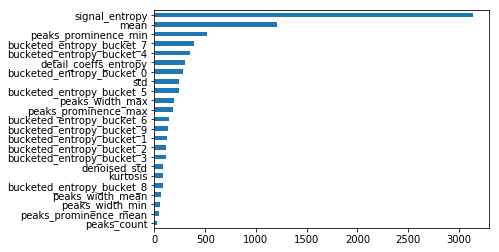

In [26]:
feature_importances.sort_values(ascending=True).plot.barh();

Save the submission.

In [27]:
sub_name = f'binary_lgb_{fit_scores.mean():.3f}_{fit_scores.std():.3f}_{val_scores.mean():.3f}_{val_scores.std():.3f}'
(submission.mean(axis='columns') > 0.5).astype('uint8').to_frame('target').to_csv(f'submissions/{sub_name}.csv')

## Multi-class classification

In [29]:
df2 = df.reset_index()\
        .drop(columns=['signal_id'])\
        .set_index(['id_measurement', 'phase'])\
        .unstack()
df2.columns = ['_'.join(pair) for pair in df2.columns]
df2.head()

,target_0,target_1,target_2,mean_0,mean_1,mean_2,std_0,std_1,std_2,kurtosis_0,...,bucketed_entropy_bucket_6_2,bucketed_entropy_bucket_7_0,bucketed_entropy_bucket_7_1,bucketed_entropy_bucket_7_2,bucketed_entropy_bucket_8_0,bucketed_entropy_bucket_8_1,bucketed_entropy_bucket_8_2,bucketed_entropy_bucket_9_0,bucketed_entropy_bucket_9_1,bucketed_entropy_bucket_9_2
id_measurement,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,-0.960271,-0.194125,-0.043555,13.870724,13.037134,13.684282,-1.433378,...,0.005060,0.004909,0.000000,0.006996,0.020417,0.002851,0.004595,0.019805,0.004747,0.000887
1,1.0,1.0,1.0,-0.997401,-0.175586,-0.036004,13.673630,12.938372,13.545777,-1.474346,...,0.004339,0.002972,0.007709,0.003797,0.010300,0.003312,0.013359,0.025864,0.005525,0.006087
2,0.0,0.0,0.0,-1.146185,-1.952695,0.873370,14.064211,14.774424,14.815668,-1.454813,...,0.000000,0.003827,0.000307,0.001726,0.002789,0.001147,0.002189,0.001194,0.002012,0.000887
3,0.0,0.0,0.0,-1.359634,0.728509,-0.817065,15.704621,15.097064,15.830916,-0.723169,...,0.000000,0.000000,0.025523,0.073711,0.021319,0.000000,0.089002,0.059498,0.000000,0.042339
4,0.0,0.0,0.0,-1.011068,-0.153133,-0.030229,13.748700,12.955183,13.538673,-1.430574,...,0.004395,0.005553,0.006935,0.006806,0.004344,0.007707,0.010380,0.007368,0.001679,0.006829


The fact that there are three phases and that there order seems arbitrary means that we can naturally augment the data by permuting the features and the targets.

In [30]:
import itertools

to_drop = ['target_0', 'target_1', 'target_2']

train = df2[df2['target_0'].notnull()]

key = lambda x: x[-1]
phase_cols = itertools.groupby(sorted(train.columns.tolist(), key=key), key)

train_aug = pd.DataFrame(
    np.vstack([
        np.hstack(permutation)
        for permutation in itertools.permutations([train[sorted(cols)].values for _, cols in phase_cols])
    ]),
    columns=sorted(train.columns, key=lambda x: x[-1] + x[:-1]),
    index=np.tile(train.index, 6)
)

X_train = train.drop(columns=to_drop)
y_train = train[['target_0', 'target_1', 'target_2']].apply(lambda x: '-'.join(map(lambda y: str(int(y)), x)), axis='columns')

X_train_aug = train_aug.drop(columns=to_drop)[X_train.columns]
y_train_aug = train_aug[['target_0', 'target_1', 'target_2']].apply(lambda x: '-'.join(map(lambda y: str(int(y)), x)), axis='columns')

is_train = df2['target_0'].notnull()
X_test = df2[~is_train].drop(columns=to_drop)[X_train.columns]

for col in X_train.columns:
    if X_train[col].isnull().sum() > 0:
        X_train[col].fillna(-1, inplace=True)
        X_train_aug[col].fillna(-1, inplace=True)
        X_test[col].fillna(-1, inplace=True)

label_to_number = {label: number for number, label in enumerate(y_train.unique())}
number_to_label = {number: label for label, number in label_to_number.items()}

In [31]:
from sklearn import model_selection


model = pipeline.Pipeline([
    ('resample', over_sampling.ADASYN(random_state=42)),
    ('lgb', lgb.LGBMClassifier(
        is_unbalance=True,
        learning_rate=0.15,
        min_child_samples=30,
        n_estimators=3000,
        importance_type='gain',
        metric='None',
        random_state=42
    ))
])

fit_scores = np.zeros(len(folds))
val_scores = np.zeros(len(folds))
feature_importances = pd.Series(0., index=X_train.columns)
submission = pd.DataFrame(0., columns=y_train.unique(), index=X_test.index)
oof = pd.DataFrame(0., index=X_train.index, columns=y_train.unique())


def split_measurement_labels(y):
    return y.str.split('-', expand=True).stack()


for i, fold in enumerate(folds):
    
    fit_ids, val_ids = fold['fit']['measurement_ids'], fold['val']['measurement_ids']
    
    X_fit_aug, y_fit_aug = X_train_aug.loc[fit_ids], y_train_aug.loc[fit_ids].map(label_to_number)
    X_fit, y_fit = X_train.loc[fit_ids], y_train.loc[fit_ids].map(label_to_number)
    X_val, y_val = X_train.loc[val_ids], y_train.loc[val_ids].map(label_to_number)
    
    model = model.fit(
        X=X_fit_aug,
        y=y_fit_aug,
        lgb__eval_set=[(X_fit, y_fit), (X_val, y_val)],
        lgb__eval_names=['fit', 'val'],
        lgb__eval_metric='multi_logloss',
        lgb__early_stopping_rounds=10,
        lgb__verbose=10
    )
    
    # Fit predictions
    y_fit_pred = pd.DataFrame(model.predict_proba(X_fit), index=X_fit.index)
    y_fit_pred.columns = y_fit_pred.columns.map(number_to_label)
    fit_scores[i] = metrics.matthews_corrcoef(
        split_measurement_labels(y_fit.map(number_to_label)),
        split_measurement_labels(y_fit_pred.idxmax(axis='columns'))
    )
    
    # Val predictions
    y_val_pred = pd.DataFrame(model.predict_proba(X_val), index=X_val.index)
    y_val_pred.columns = y_val_pred.columns.map(number_to_label)
    oof.loc[y_val_pred.index, y_val_pred.columns] = y_val_pred
    val_scores[i] = metrics.matthews_corrcoef(
        split_measurement_labels(y_val.map(number_to_label)),
        split_measurement_labels(y_val_pred.idxmax(axis='columns'))
    )
    
    # Test predictions
    y_pred = pd.DataFrame(model.predict_proba(X_test), index=X_test.index)
    y_pred.columns = y_pred.columns.map(number_to_label)
    submission.loc[y_pred.index, y_pred.columns] += y_pred / len(folds)
    
    print()
    
train_meta = pd.read_csv('data/kaggle/metadata_train.csv')
train_pred = oof.idxmax(axis='columns').str.split('-', expand=True).stack().to_frame('pred')
train_pred = train_meta.join(train_pred, how='right', on=['id_measurement', 'phase'])
train_pred['pred'].to_csv('oof/multi_lgb.csv')
    
print(f'- Fit MCC: {fit_scores.mean():.3f} (± {fit_scores.std():.3f})')
print(f'- Val MCC: {val_scores.mean():.3f} (± {val_scores.std():.3f})')

Training until validation scores don't improve for 10 rounds.
[10]	fit's multi_logloss: 0.554723	val's multi_logloss: 0.63349
[20]	fit's multi_logloss: 0.246683	val's multi_logloss: 0.341139
[30]	fit's multi_logloss: 0.130626	val's multi_logloss: 0.237046
[40]	fit's multi_logloss: 0.0753596	val's multi_logloss: 0.199255
[50]	fit's multi_logloss: 0.0454669	val's multi_logloss: 0.187301
[60]	fit's multi_logloss: 0.028434	val's multi_logloss: 0.188426
Early stopping, best iteration is:
[52]	fit's multi_logloss: 0.0413797	val's multi_logloss: 0.186535

Training until validation scores don't improve for 10 rounds.
[10]	fit's multi_logloss: 0.538843	val's multi_logloss: 0.609491
[20]	fit's multi_logloss: 0.24949	val's multi_logloss: 0.3455
[30]	fit's multi_logloss: 0.133696	val's multi_logloss: 0.242201
[40]	fit's multi_logloss: 0.077695	val's multi_logloss: 0.196947
[50]	fit's multi_logloss: 0.0470703	val's multi_logloss: 0.176209
[60]	fit's multi_logloss: 0.0287911	val's multi_logloss: 0.1

/home/max/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


In [32]:
sub_name = f'multi_lgb_{fit_scores.mean():.3f}_{fit_scores.std():.3f}_{val_scores.mean():.3f}_{val_scores.std():.3f}'

test_meta = pd.read_csv('data/kaggle/metadata_test.csv')
sub = split_measurement_labels(submission.idxmax(axis='columns')).to_frame('target')
sub = test_meta.join(sub, how='right', on=['id_measurement', 'phase'])
sub[['signal_id', 'target']].to_csv(f'submissions/{sub_name}.csv', index=False)